In [1]:
# Physics modules
from metric import metric
from hybrid_eos import hybrid_eos

# Numpy and matplotlib
import numpy as np 
import matplotlib.pyplot as plt 

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init 
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
import matplotlib.pyplot as plt

In [2]:

use_fp64 = True  # Toggle this to switch precision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dtype = torch.float64 if use_fp64 else torch.float32


In [3]:
class c2p_NN(nn.Module):
    """
    This class defines a neural network model for the conservative-to-primitive variable transformation.
    The network consists of several fully connected layers with ReLU activation functions and batch normalization.
    The input to the network is a tensor of conservative variables, and the output is a tensor of primitive variables.
    """
    def __init__(self, hidden_layers=3, neurons=50):
        super(c2p_NN, self).__init__()
        self.activation = nn.Tanh 
        input_dim = 3 
        output_dim = 1 
        layers = []
        layers.append(nn.BatchNorm1d(input_dim))
        layers.append(nn.Linear(input_dim, neurons))  # Input layer
        layers.append(self.activation())  # Activation
        for _ in range(hidden_layers):
            layers.append(nn.Linear(neurons, neurons))  # Hidden layers
            layers.append(nn.BatchNorm1d(neurons)) # Normalization
            layers.append(self.activation())  # Activation
            
        layers.append(nn.Linear(neurons, output_dim))  # Output layer
        # Last relu because z >= 0 
        layers.append(nn.ReLU()                     )  # Activation
        self.network = nn.Sequential(*layers)
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """ Initialize weights using Kaiming initialization """
        if isinstance(module, nn.Linear):
            #init.kaiming_normal_(module.weight, nonlinearity="relu")
            init.xavier_normal_(module.weight)
            init.zeros_(module.bias)
    
    def forward(self, x):
        return self.network(x)


In [4]:
class c2p_NN(nn.Module):
    """
    This class defines a neural network model for the conservative-to-primitive variable transformation.
    The network consists of several fully connected layers with ReLU activation functions and batch normalization.
    The input to the network is a tensor of conservative variables, and the output is a tensor of primitive variables.
    """
    def __init__(self, dtype=dtype):
        super(c2p_NN, self).__init__()
        self.activation = nn.Tanh 
        input_dim = 3 
        output_dim = 1 
        layers = []
        # Layer 1 
        layers.append(nn.Linear(input_dim, 400,dtype=dtype))  # Input layer
        #layers.append(nn.BatchNorm1d(400))
        layers.append(self.activation())
        # Layer 2 
        layers.append(nn.Linear(400, 200,dtype=dtype))
        #layers.append(nn.BatchNorm1d(200))
        layers.append(self.activation())
        # Layer 3 
        layers.append(nn.Linear(200, 100,dtype=dtype))
        #layers.append(nn.BatchNorm1d(100))
        layers.append(self.activation())
        # Layer 4 
        layers.append(nn.Linear(100, 1, dtype=dtype))        
        # Output 
        layers.append(nn.Softplus())  # Activation
        
        self.network = nn.Sequential(*layers)  
        
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """ Initialize weights using Kaiming initialization """
        if isinstance(module, nn.Linear):
            #init.kaiming_normal_(module.weight, nonlinearity="relu")
            init.xavier_normal_(module.weight)
            init.zeros_(module.bias)
    
    def forward(self, x):
        return self.network(x)

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # Use 'relu' for SiLU
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Initialize biases to 0


class C2PNet(nn.Module):
    def __init__(self, dtype=torch.float64):
        super(C2PNet, self).__init__()
        self.fc1 = nn.Linear(3, 64, dtype=dtype)
        self.fc2 = nn.Linear(64, 128, dtype=dtype)
        self.fc3 = nn.Linear(128, 128, dtype=dtype)
        self.fc4 = nn.Linear(128, 64, dtype=dtype)
        self.fc5 = nn.Linear(64+3, 1, dtype=dtype)  # Single output z = W v
        self.activation = nn.SiLU()  # Smooth activation
        self.output = nn.ReLU() # Ensure positivity of z
        self.apply(init_weights)
        
    def forward(self, x):
        identity = x  # Residual connection using one input component
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = torch.cat([x, identity], dim=1)
        x = self.output(self.fc5(x))   # Residual connection
        return x

In [6]:
class C2P_Dataset(TensorDataset):
    
    def __init__(self,C,Z,normalize_data=True):
        
        self.C = C.to(dtype)
        self.Z = Z.to(dtype)
        
        if normalize_data:
            self.normalize()
        
    def normalize(self):
        self.C_max = torch.max(self.C, dim=0, keepdim=True)[0]
        self.C_min = torch.min(self.C, dim=0, keepdim=True)[0]
        self.C = (self.C - self.C_min)/(self.C_max-self.C_min)
        self.Z_max = torch.max(self.Z, dim=0, keepdim=True)[0]
        self.Z_min = torch.min(self.Z, dim=0, keepdim=True)[0]
        self.Z = (self.Z - self.Z_min)/(self.Z_max-self.Z_min)
        
    def __len__(self):
        return self.C.shape[0]
    
    def __getitem__(self,idx):
        return self.C[idx,:], self.Z[idx,:]


In [7]:
# Minkowski metric 
eta = metric(
torch.eye(3,device=device), torch.zeros(3,device=device), torch.ones(1,device=device)
)
# Gamma = 2 EOS with ideal gas thermal contrib 
eos = hybrid_eos(100,2,1.8)

In [8]:
def setup_initial_state_random(metric,eos,N,device,lrhomin=-12,lrhomax=-2.8,ltempmin=-1,ltempmax=2.3,Wmin=1,Wmax=2):
    # Get W, rho and T 
    W = Wmin + (Wmax-Wmin) * torch.rand(N,device=device)
    rho = 10**lrhomin + (10**lrhomax-10**lrhomin) * torch.rand(N,device=device) 
    T = torch.zeros_like(rho,device=device)
    # Call EOS to get press and eps 
    press,eps = eos.press_eps__temp_rho(T,rho)
    # Compute z 
    Z = torch.sqrt(1 - 1/W**2) * W 
    
    # Compute conserved vars 
    sqrtg = metric.sqrtg 
    u0 = W / sqrtg 
    dens = sqrtg * W * rho 
    
    rho0_h = rho * ( 1 + eps ) + press 
    g4uptt = - 1/metric.alp**2 
    Tuptt = rho0_h * u0**2 + press * g4uptt 
    tau = metric.alp**2 * sqrtg * Tuptt - dens 
    
    S = torch.sqrt((W**2-1)) * rho0_h * W
    # Assemble output 
    C = torch.cat((dens.view(-1,1)/metric.sqrtg,tau.view(-1,1)/dens.view(-1,1),S.view(-1,1)/dens.view(-1,1)),dim=1)
    return C, Z.view(-1,1)

def setup_initial_state_meshgrid(metric,eos,N,device,lrhomin=-12,lrhomax=-2.8,ltempmin=-1,ltempmax=2.3,Wmin=1,Wmax=2):
    # Get W, rho and T 
    W = torch.linspace(Wmin,Wmax,N,device=device)
    rho = 10**( torch.linspace(lrhomin,lrhomax,N,device=device) )
    T = 10**( torch.linspace(ltempmin,ltempmax,N,device=device) )
    W, rho, T = torch.meshgrid(W,rho,T, indexing='ij')
    
    W = W.flatten() 
    rho = rho.flatten()
    T = T.flatten() 
    
    # Call EOS to get press and eps 
    press,eps = eos.press_eps__temp_rho(T,rho)
    # Compute z 
    Z = torch.sqrt(1 - 1/W**2) * W 
    
    # Compute conserved vars 
    sqrtg = metric.sqrtg 
    u0 = W / sqrtg 
    dens = sqrtg * W * rho 
    
    rho0_h = rho * ( 1 + eps ) + press 
    g4uptt = - 1/metric.alp**2 
    Tuptt = rho0_h * u0**2 + press * g4uptt 
    tau = metric.alp**2 * sqrtg * Tuptt - dens 
    
    S = torch.sqrt((W**2-1)) * rho0_h * W
    # Assemble output 
    C = torch.cat((dens.view(-1,1)/metric.sqrtg,tau.view(-1,1)/dens.view(-1,1),S.view(-1,1)/dens.view(-1,1)),dim=1)
    return C, Z.view(-1,1)

def setup_initial_state_zerov(metric,eos,N,device,lrhomin=-12,lrhomax=-2.8):
    rho = 10**(torch.linspace(lrhomin,lrhomax,N,device=device))
    
    W = torch.ones_like(rho,device=device) 
    T = torch.zeros_like(rho,device=device)
    
    # Call EOS to get press and eps 
    press,eps = eos.press_eps__temp_rho(T,rho)
    # Compute z 
    Z = torch.sqrt(1 - 1/W**2) * W 
    
    # Compute conserved vars 
    sqrtg = metric.sqrtg 
    u0 = W / sqrtg 
    dens = sqrtg * W * rho 
    
    rho0_h = rho * ( 1 + eps ) + press 
    g4uptt = - 1/metric.alp**2 
    Tuptt = rho0_h * u0**2 + press * g4uptt 
    tau = metric.alp**2 * sqrtg * Tuptt - dens 
    
    S = torch.sqrt((W**2-1)) * rho0_h * W
    # Assemble output 
    C = torch.cat((dens.view(-1,1)/metric.sqrtg,tau.view(-1,1)/dens.view(-1,1),S.view(-1,1)/dens.view(-1,1)),dim=1)
    return C, Z.view(-1,1)

def setup_initial_state_meshgrid_cold(metric,eos,N,device,lrhomin=-12,lrhomax=-2.8,Wmin=1.,Wmax=2):
    # Get W, rho and T 
    W   = torch.linspace(Wmin,Wmax,N,device=device)
    rho = 10**(torch.linspace(lrhomin,lrhomax,N,device=device))
    
    # Meshgrid
    rho, W = torch.meshgrid(rho,W, indexing='ij')
    
    # Flatten
    rho = rho.flatten()
    W = W.flatten() 
    
    # Temperature (0)
    T   = torch.zeros_like(rho,device=device)
    
    # Call EOS to get press and eps 
    press,eps = eos.press_eps__temp_rho(T,rho)
    # Compute z 
    Z = torch.sqrt(1 - 1/W**2) * W 
    
    # Compute conserved vars 
    sqrtg = metric.sqrtg 
    u0 = W / sqrtg 
    dens = sqrtg * W * rho 
    
    rho0_h = rho * ( 1 + eps ) + press 
    g4uptt = - 1/metric.alp**2 
    Tuptt = rho0_h * u0**2 + press * g4uptt 
    tau = metric.alp**2 * sqrtg * Tuptt - dens 
    
    S = torch.sqrt((W**2-1)) * rho0_h * W
    # Assemble output 
    C = torch.cat((dens.view(-1,1)/metric.sqrtg,tau.view(-1,1)/dens.view(-1,1),S.view(-1,1)/dens.view(-1,1)),dim=1)
    return C, Z.view(-1,1)
    
def sanity_check(Z,C, metric, eos):
    t,q,r = torch.split(C,[1,1,1], dim=1)
    htilde = h__z(Z,C,eos)
    
    return torch.mean((Z - r/htilde)**2)

def W__z(z):
    return torch.sqrt(1 + z**2)

def rho__z(z,C):
    return C[:,0].view(-1,1) / W__z(z)

def eps__z(z,C):
    q = C[:,1].view(-1,1)
    r = C[:,2].view(-1,1)
    W = W__z(z)
    return W * q - z * r + z**2/(1+W)

def a__z(z,C,eos):
    eps = eps__z(z,C)
    rho = rho__z(z,C)
    press = eos.press__eps_rho(eps,rho)
    return press/(rho*(1+eps))

def h__z(z,C,eos):
    eps = eps__z(z,C)
    a = a__z(z,C,eos)
    return (1 + eps)*(1+a)

In [9]:
# Generate some data
C, Z = setup_initial_state_meshgrid_cold(eta,eos,200,device,Wmin=1.2,Wmax=1.8)
# Create a dataset 
dataset = C2P_Dataset(C, Z)
# Set up dataloader 
batch_size = 32  # You can experiment with this

# Define split sizes
train_size = int(0.8 * len(dataset))  # 80% training
val_size = len(dataset) - train_size  # 20% validation

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

err = sanity_check(Z,C,eta,eos)

print(err)

tensor(7.6486e-14, device='cuda:0')


In [10]:
print(torch.max(Z,dim=0,keepdim=True)[0])

tensor([[1.4967]], device='cuda:0')


In [11]:
# Save dataset properties 
torch.save(dataset.C_max.to(torch.device("cpu")),'C_max.pt')
torch.save(dataset.C_min.to(torch.device("cpu")),'C_min.pt')
torch.save(dataset.Z_max.to(torch.device("cpu")),'Z_max.pt')
torch.save(dataset.Z_min.to(torch.device("cpu")),'Z_min.pt')

In [12]:
def log_cosh_loss(y_true, y_pred):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def compute_loss(model, C,C_min, C_max,  Z,Z_min,Z_max, eos):
    '''
    Eq (C3) of https://arxiv.org/pdf/1306.4953.pdf
    '''
    dtype = torch.float64
    Z_pred = model(C) # Data is normalized inside dataset constructor 
    Z_pred_real = Z_pred * ( Z_max - Z_min ) + Z_min 
    C_real = C * (C_max - C_min) + C_min
    Z_real = Z * (Z_max - Z_min) + Z_min
    htilde = h__z(Z_pred_real,C_real,eos)
    MSEr = log_cosh_loss(Z_pred_real,C_real[:,2].view(-1,1)/htilde).to(dtype)
 
    return log_cosh_loss(Z_pred,Z).to(dtype) + MSEr 

In [13]:
def train_c2p_model(
    model,optimizer,scheduler,
    training_loader,validation_loader,C_min,C_max,Z_min,Z_max,
    num_epochs,eos,
    training_loss,validation_loss
    ):
    for epoch in range(num_epochs):
        epoch_loss = 0 
        
        for C_data,Z_data in training_loader:
            optimizer.zero_grad()
            
            loss = compute_loss(model,C_data,C_min,C_max,Z_data,Z_min,Z_max,eos)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() 
        epoch_loss /= len(training_loader)
        
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_loss)
        else:
            scheduler.step()
        # Compute test loss 
        test_loss = 0
        with torch.no_grad():
            for C_test,Z_test in validation_loader:
                test_loss += compute_loss(model, C_test,C_min,C_max,Z_test,Z_min,Z_max, eos).item()

        test_loss /= len(validation_loader)

        training_loss.append(epoch_loss)
        validation_loss.append(test_loss)
        
        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss:.3e}, Test loss: {test_loss:.3e}")

In [18]:
print(10000//len(train_dataloader))

10


In [14]:
n_epochs = 200

training_loss = []
validation_loss = []

#net = c2p_NN().to(device).to(dtype)
net = C2PNet(dtype).to(device).to(dtype)
for param in net.parameters():
    if param.grad is not None:
        param.grad = param.grad.to(dtype)

optimizer = optim.Adam(net.parameters(), lr=1e-3)
for param_group in optimizer.param_groups:
    param_group['params'] = [p.to(dtype) for p in param_group['params']]




scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

train_c2p_model(net,optimizer,scheduler,train_dataloader,val_dataloader,dataset.C_min,dataset.C_max,dataset.Z_min,dataset.Z_max,n_epochs,eos,training_loss,validation_loss)

# Do one more step with LBFGS
optimizer = torch.optim.LBFGS(net.parameters(), lr=0.1, max_iter=50)

def closure():
    optimizer.zero_grad()
    loss = compute_loss(net, dataset.C, dataset.C_min, dataset.C_max, dataset.Z, dataset.Z_min, dataset.Z_max, eos)
    loss.backward()
    return loss

optimizer.step(closure)

loss_value = closure()  # Compute the loss
print(f"Final loss: {loss_value.item()}")  

#torch.save(net.state_dict(), f"model_L{layers}N{neurons}.pt")

/mnt/rafast/musolino/pyenv/numrel/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Epoch 0, Loss: 5.587e-04, Test loss: 2.698e-07
Epoch 10, Loss: 9.525e-06, Test loss: 3.444e-07
Epoch 20, Loss: 3.248e-07, Test loss: 1.278e-07
Epoch 30, Loss: 2.671e-07, Test loss: 1.790e-08


KeyboardInterrupt: 

In [150]:
for param in net.parameters():
    print(param.dtype)

torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64


In [200]:
# Do one more step with LBFGS
optimizer = torch.optim.LBFGS(net.parameters(), lr=0.1, max_iter=20)

def closure():
    optimizer.zero_grad()
    loss = compute_loss(net, dataset.C, dataset.C_min, dataset.C_max, dataset.Z, dataset.Z_min, dataset.Z_max, eos)
    loss.backward()
    return loss

for i in range(100):
    optimizer.step(closure)
    if i%10 == 0:
        print(f"Loss: {closure().item()}")   

Loss: 4.024920991859804e-11
Loss: 4.024920991859804e-11
Loss: 4.024920991859804e-11
Loss: 4.024920991859804e-11
Loss: 4.024920991859804e-11
Loss: 4.024920991859804e-11
Loss: 4.024920991859804e-11
Loss: 4.024920991859804e-11
Loss: 4.024920991859804e-11
Loss: 4.024920991859804e-11


In [ ]:
7.984e-06

With batchnorm:  7.984e-06

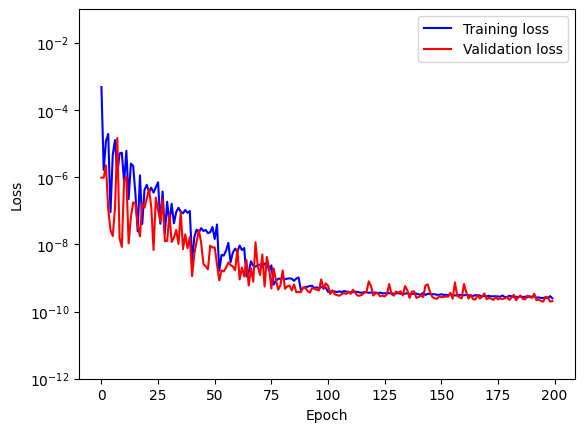

In [159]:
fig,ax = plt.subplots()
ax.semilogy(training_loss,label='Training loss', color="blue")
ax.semilogy(validation_loss,label='Validation loss', color="red")


ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_ylim(1e-12,1e-1)
plt.savefig("new_loss_fp64.pdf")

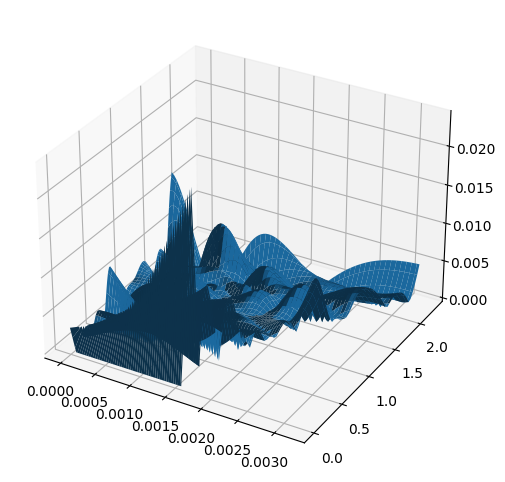

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

DD = C[:,0].cpu().view(100,100).detach().numpy()
SS = C[:,2].cpu().view(100,100).detach().numpy()

Z_pred = net(C).view(100,100).cpu().detach().numpy()

ax.plot_surface(DD,SS,np.abs(Z.view(100,100).cpu().detach().numpy()-Z_pred),label='True')
#ax.scatter3D(DD,SS,Z_pred,label='Predicted',color='red',s=0.1)


In [ ]:
torch.save(net.state_dict(), "model.pt")

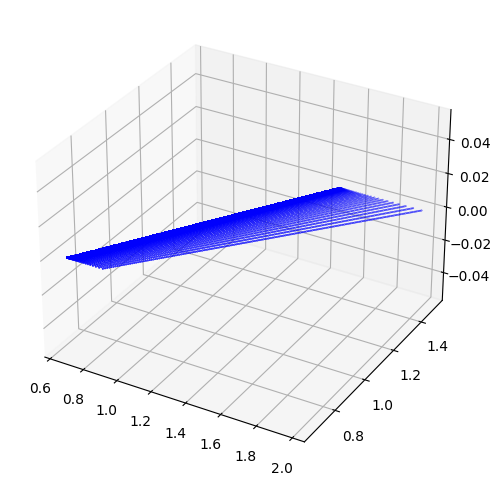

In [96]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(C[:,2].cpu().numpy(),Z.cpu().detach().numpy(),label='True',color='blue',s=.1)
ax.scatter(C[:,2].cpu().numpy(),Z_pred,label='Predicted',color='blue',s=.1)


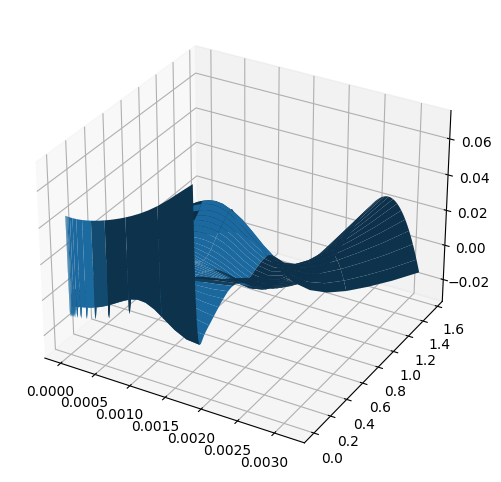

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

Z_pred = net((C-C_mean)/C_std).view(200,200).cpu().detach().numpy()
DD = C[:,0].cpu().view(200,200).detach().numpy()
TT = C[:,1].cpu().view(200,200).detach().numpy()
SS = C[:,2].cpu().view(200,200).detach().numpy()
ZZ = Z.cpu().view(200,200).detach().numpy()
ax.plot_surface(DD,TT,Z_pred-ZZ,label='True')

/tmp/ipykernel_2876951/4278129378.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(C[:,0].cpu().numpy(),np.log10(np.abs(Z.cpu().detach().numpy()-Z_pred)),label='Predicted',color='red',s=1)


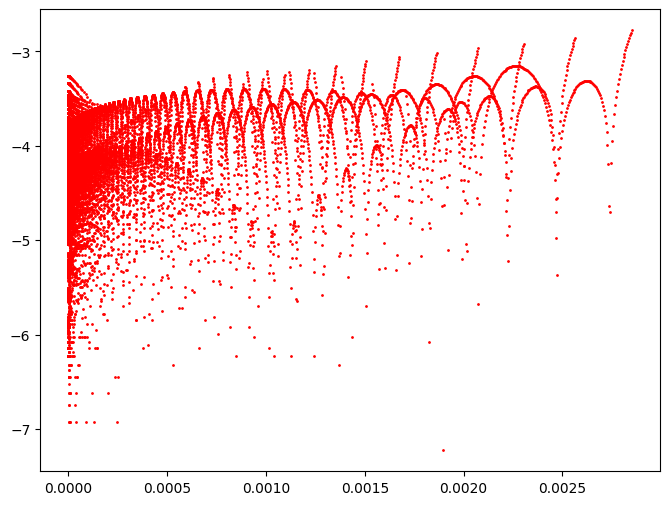

In [95]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

#C_test, Z_test = setup_initial_state_random(eta,eos,1000,device)
#Z_test = Z_test.cpu().numpy()
#Z_pred_test = net(C_test).cpu().detach().numpy()
Z_pred = net(dataset.C).cpu().detach().numpy()


ax.scatter(C[:,0].cpu().numpy(),np.log10(np.abs(Z.cpu().detach().numpy()-Z_pred)),label='Predicted',color='red',s=1)

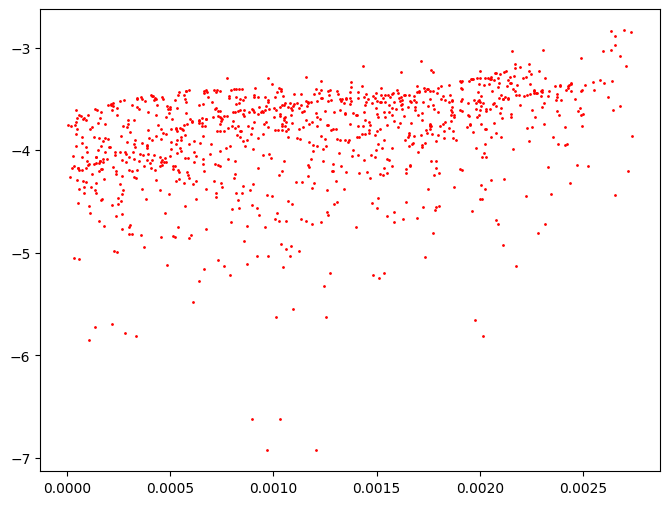

In [99]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

C_test, Z_test = setup_initial_state_random(eta,eos,1000,device,Wmin=1.2,Wmax=1.8)
Z_test = Z_test.cpu().numpy()
Z_pred_test = net((C_test-dataset.C_min)/(dataset.C_max-dataset.C_min)).cpu().detach().numpy()
Z_pred = net(C).cpu().detach().numpy()

ax.scatter(C_test[:,0].cpu().numpy(),np.log10(np.abs(Z_test-Z_pred_test)),label='Predicted',color='red',s=1)

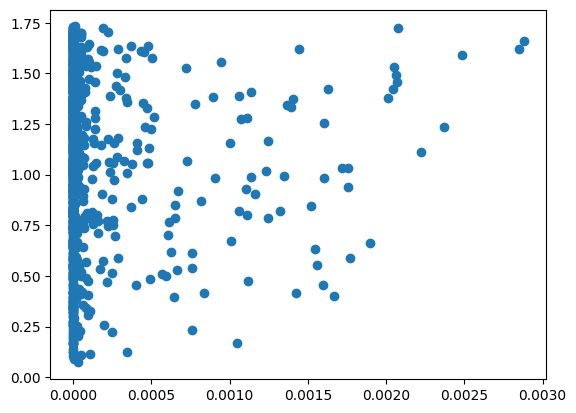

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

C_test, Z_test = setup_initial_state_random(eta,eos,1000,device)
Z_test = Z_test.cpu().numpy()
Z_pred_test = net(C_test).cpu().detach().numpy()

ax.scatter(C_test[:,0].cpu().numpy(),np.log10(np.abs(Z_test-Z_pred_test)),label='Predicted',color='red',s=1)


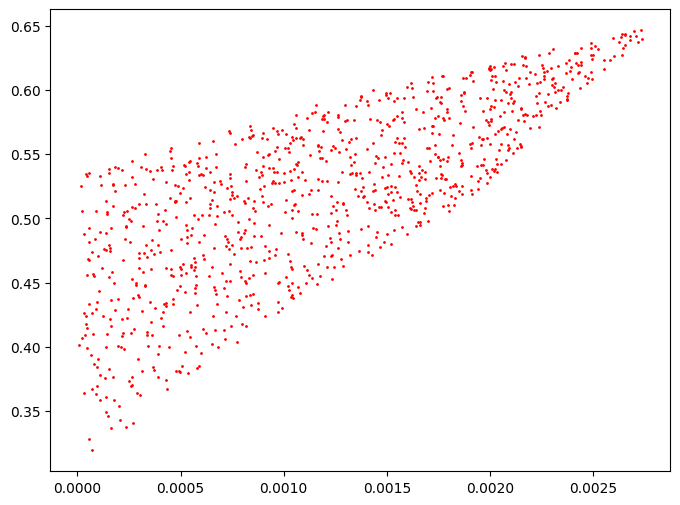

In [103]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(C_test[:,0].cpu().numpy(),C_test[:,1].cpu().numpy()/C_test[:,2].cpu().numpy(),label='Predicted',color='red',s=1)

In [ ]:
10**2.3

199.52623149688787

In [246]:
class c2p:
    
    def __init__(self,model,eos,C_min,C_max,Z_min,Z_max):
        self.model = model
        self.C_min = C_min
        self.C_max = C_max
        self.Z_min = Z_min
        self.Z_max = Z_max 
        self.eos = eos 
    
    def invert(self,C):
        with torch.no_grad():
            Z = self.model((C-self.C_min)/(self.C_max-self.C_min))
        Z = Z * (self.Z_max-self.Z_min) + self.Z_min
        
        rho = rho__z(Z,C)
        W   = W__z(Z)
        eps = eps__z(Z,C)
        press = self.eos.press__eps_rho(eps,rho)
        return rho,eps,press,W 

In [167]:
torch.save(net.state_dict(), "model_11.pt")

In [263]:
# Get W, rho and T 
Wmin = 1.2 
Wmax = 1.8 
lrhomin = -12
lrhomax = -2.8
N = 200
W   = torch.linspace(Wmin,Wmax,N,device=device)
rho = 10**(torch.linspace(lrhomin,lrhomax,N,device=device))

# Meshgrid
rhom, Wm = torch.meshgrid(rho,W, indexing='ij')

# Flatten
rho = rhom.flatten()
W = Wm.flatten() 

# Temperature (0)
T   = torch.zeros_like(rho,device=device)

# Call EOS to get press and eps 
press,eps = eos.press_eps__temp_rho(T,rho)
# Compute z 
Z = torch.sqrt(1 - 1/W**2) * W 

# Compute conserved vars 
sqrtg = eta.sqrtg 
u0 = W / sqrtg 
dens = sqrtg * W * rho 

rho0_h = rho * ( 1 + eps ) + press 
g4uptt = - 1/eta.alp**2 
Tuptt = rho0_h * u0**2 + press * g4uptt 
tau = eta.alp**2 * sqrtg * Tuptt - dens 

S = torch.sqrt((W**2-1)) * rho0_h * W
# Assemble output 
C = torch.cat((dens.view(-1,1)/eta.sqrtg,tau.view(-1,1)/dens.view(-1,1),S.view(-1,1)/dens.view(-1,1)),dim=1).to(dtype)

In [267]:
inverter = c2p(net,eos,dataset.C_min,dataset.C_max,dataset.Z_min,dataset.Z_max)
rho_pred,eps_pred,press_pred,W_pred = inverter.invert(C)

(200, 200) (200, 200) (200, 200) (200, 200)
torch.Size([40000])


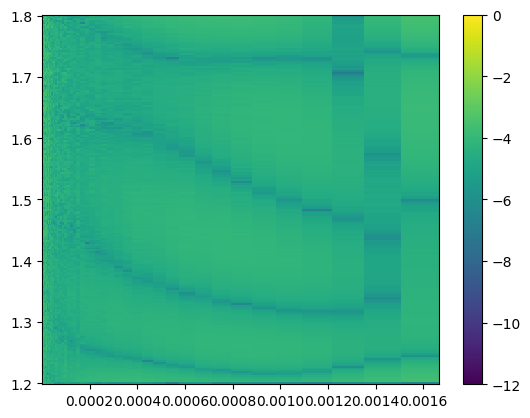

In [268]:
fig,ax = plt.subplots() 

RHO = rhom.view(N,N).cpu().detach().numpy()
WW  = Wm.view(N,N).cpu().detach().numpy()

rho_res = (torch.abs(rho_pred-rho.view(-1,1))/rho.view(-1,1)).view(N,N).cpu().detach().numpy()
eps_res = (torch.abs(eps_pred-eps.view(-1,1))/eps.view(-1,1)).view(N,N).cpu().detach().numpy()
press_res = (torch.abs(press_pred-press.view(-1,1))/press.view(-1,1)).view(N,N).cpu().detach().numpy()
W_res = (torch.abs(W_pred-W.view(-1,1))/W.view(-1,1)).view(N,N).cpu().detach().numpy()

residual = rho_res + eps_res + press_res + W_res

print(rho_res.shape,eps_res.shape,press_res.shape,W_res.shape)
print(W.shape)
a = ax.pcolormesh(RHO,WW,np.log10(residual), vmin=-12, vmax=0)
plt.colorbar(a)

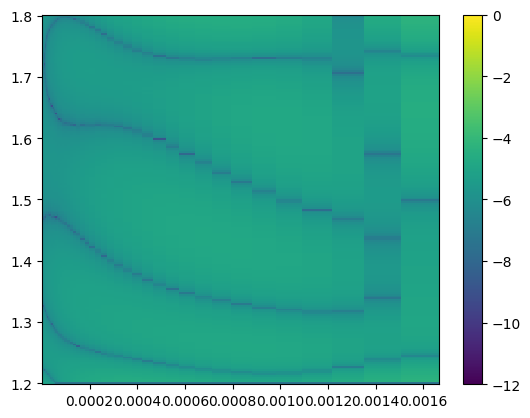

In [269]:
fig,ax = plt.subplots() 
a = ax.pcolormesh(RHO,WW,np.log10(W_res), vmin=-12, vmax=0)
plt.colorbar(a)

/tmp/ipykernel_2876951/823191377.py:7: RuntimeWarning: divide by zero encountered in log10
  a = ax.pcolormesh(RHO,WW,np.log10(np.abs(Z.view(N,N).detach().cpu().numpy()-Zp)))


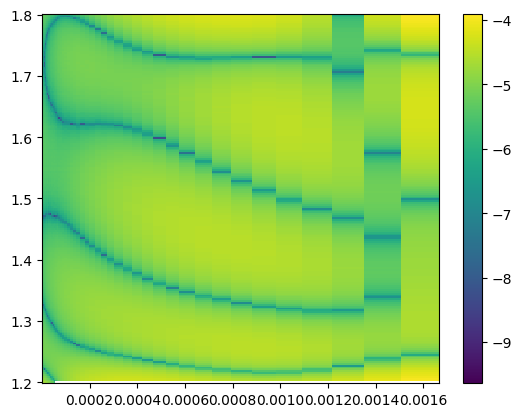

In [270]:
with torch.no_grad():
    Zp = net((C-dataset.C_min)/(dataset.C_max-dataset.C_min))
Zp = Zp * (dataset.Z_max-dataset.Z_min) + dataset.Z_min
Zp = Zp.view(N,N).detach().cpu().numpy()
fig, ax = plt.subplots() 

a = ax.pcolormesh(RHO,WW,np.log10(np.abs(Z.view(N,N).detach().cpu().numpy()-Zp)))
plt.colorbar(a)

In [185]:
Zp = net(C*(dataset.C_max-dataset.C_min)+dataset.C_min)
print(Zp.shape)
Zp = Zp *( dataset.Z_max - dataset.Z_min) + dataset.Z_min
print(Zp.shape)
Wp = W__z(Zp)
print(Wp.shape)
rho = rho__z(Zp,C)
print(rho.shape)
eps = eps__z(Zp,C)
print(eps.shape)
press = eos.press__eps_rho(eps,rho)
print(press.shape)


torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])


In [271]:
print(compute_loss(net,(C-dataset.C_min)/(dataset.C_max-dataset.C_min),dataset.C_min,dataset.C_max,(Z-dataset.Z_min)/(dataset.Z_max-dataset.Z_min),dataset.Z_min,dataset.Z_max,eos))

OutOfMemoryError: HIP out of memory. Tried to allocate 11.92 GiB. GPU 0 has a total capacity of 15.98 GiB of which 2.79 GiB is free. Of the allocated memory 12.22 GiB is allocated by PyTorch, and 478.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_HIP_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)